# Classification analysis (titanic data)

## Libraries and settings

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

# Show version of scikit-learn
import sklearn
sklearn.__version__

/Users/john/School/Sem5/DA/data_analytics/Week_09


'1.3.2'

## Import titanic data

In [2]:
# Read and select variables
df_titanic_orig = pd.read_csv("titanic.csv", sep=",", encoding="utf-8")

# Number of rows and columns
print(df_titanic_orig.shape)

# First records
df_titanic_orig.head(5)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Variable description

- PassengerId passenger identification number
- Survival survival status (0 = No; 1 = Yes)
- Pclass passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
- Name name
- Sex sex
- Age age 
- SibSp number of siblings/spouses aboard
- Parch number of parents/children aboard
- Ticket ticket number
- Fare passenger fare (British pound)
- Cabin cabin
- Embarked port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

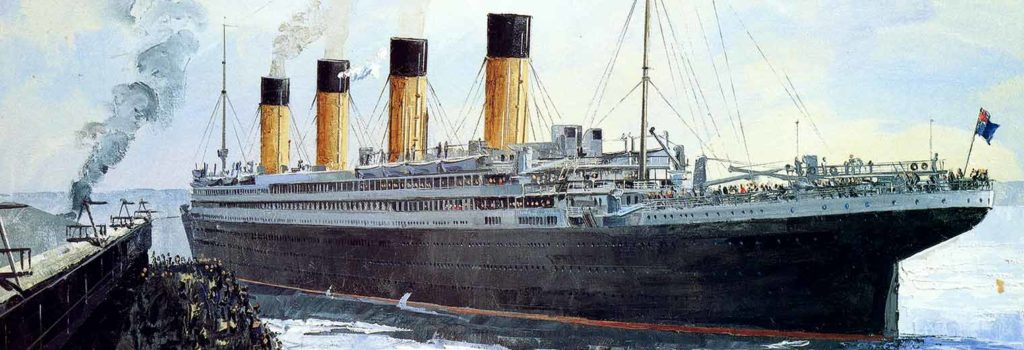

In [3]:
Image("img.jpg", width='800')

## Count and remove missing values

In [4]:
# Count missing values
print(df_titanic_orig.isna().sum())

# Remove missing values
df_titanic = df_titanic_orig.dropna(subset=['Survived', 'Sex', 'Age', 'Pclass', 'Fare'])

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [63]:
# Count missing values
print(df_titanic.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          529
Embarked         2
Sex_male         0
dtype: int64


## Barchart survival status count by gender

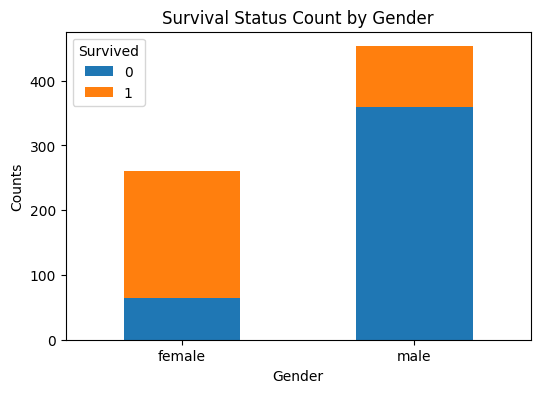

In [5]:
# Create a pivot table
table = df_titanic[['Sex', 'Survived']].pivot_table(index='Sex', 
                                        columns=['Survived'], 
                                        aggfunc=len)

# Plot a stacked bar chart
table.plot(kind='bar', 
           stacked=True, 
           ylabel='Counts', 
           xlabel='Gender',
           title='Survival Status Count by Gender', 
           rot=0,
           figsize=(6,4))

plt.show()

## Pivot table

In [6]:
# Using pivot_table to reshape the data and calculate means 
pd.pivot_table(df_titanic[['Survived',
                           'Age',
                           'Sex',
                           'Fare',
                           'Pclass']],
               index=['Survived', 'Sex'],
               values=['Age', 'Fare', 'Pclass'],
               aggfunc=(np.mean, 'count')).round(0)

Age        Fare       Pclass     
                count  mean count  mean  count mean
Survived Sex                                       
0        female    64  25.0    64  23.0     64  3.0
         male     360  32.0   360  23.0    360  2.0
1        female   197  29.0   197  56.0    197  2.0
         male      93  27.0    93  44.0     93  2.0

## Transform nominal variable to matrix with 0/1 values

In [7]:
male = pd.get_dummies(df_titanic, drop_first=False, columns=['Sex'])
male[['Sex_female', 'Sex_male']].head()

,Sex_female,Sex_male
0,False,True
1,True,False
2,True,False
3,True,False
4,False,True


## Create binary variable 'Sex_male' (wth 0=no, 1=yes)

In [8]:
df_titanic['Sex_male'] = male['Sex_male']
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True


## Classification Tree
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [9]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_titanic[['Age', 
                                                                'Sex_male',
                                                                'Pclass',
                                                                'Fare']], 
                                                                df_titanic['Survived'], 
                                                                test_size=0.20, 
                                                                random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
      Age  Sex_male  Pclass     Fare
328  31.0     False       3  20.5250
73   26.0      True       3  14.4542
253  30.0      True       3  16.1000
719  33.0      True       3   7.7750
666  25.0      True       2  13.0000 

y_train:
328    1
73     0
253    0
719    0
666    0
Name: Survived, dtype: int64


### Fit the classification tree model and make predictions

In [12]:
# Initialize the classification tree model 
clf = DecisionTreeClassifier(random_state=20, 
                             max_depth=3)

# Train the classification tree model 
clf = clf.fit(X_train, y_train)

# Make model predictions
y_pred = clf.predict(X_test)
y_pred

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

### Show confusion matrix and classification report

In [11]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred), '\n')

# Classification report
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[73 14]
 [22 34]] 

Classification report
              precision    recall  f1-score   support

           0       0.77      0.84      0.80        87
           1       0.71      0.61      0.65        56

    accuracy                           0.75       143
   macro avg       0.74      0.72      0.73       143
weighted avg       0.74      0.75      0.74       143



### Print text representation of the classification tree

In [13]:
# Text representation of the classification tree
text_rep = tree.export_text(clf, 
                            feature_names=list(X_train.columns))

# Print text_representation
print(text_rep)

|--- Sex_male <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Age <= 2.50
|   |   |   |--- class: 0
|   |   |--- Age >  2.50
|   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Age <= 27.50
|   |   |   |--- class: 1
|   |   |--- Age >  27.50
|   |   |   |--- class: 0
|--- Sex_male >  0.50
|   |--- Age <= 3.50
|   |   |--- Pclass <= 2.50
|   |   |   |--- class: 1
|   |   |--- Pclass >  2.50
|   |   |   |--- class: 0
|   |--- Age >  3.50
|   |   |--- Pclass <= 1.50
|   |   |   |--- class: 0
|   |   |--- Pclass >  1.50
|   |   |   |--- class: 0



## Visualize the classification tree

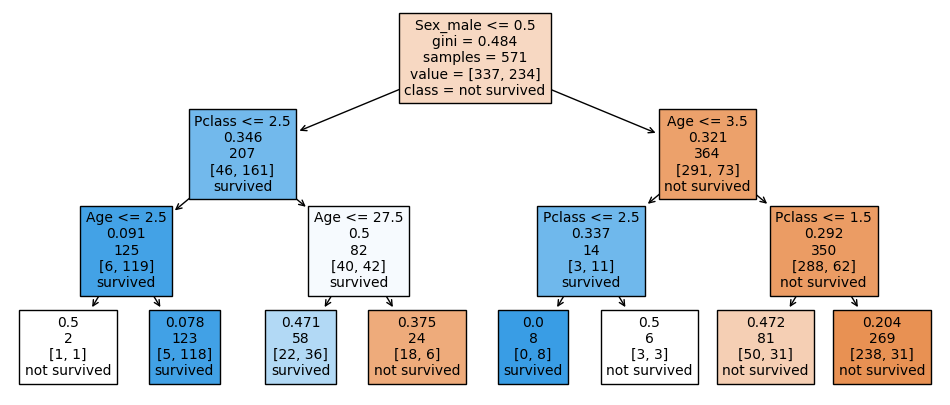

In [14]:
# For the meaning of numbers in boxes see root node
fig = plt.figure(figsize=(12,5))
tree_plot = tree.plot_tree(clf, 
                   feature_names=list(X_train.columns),  
                   class_names=['not survived', 'survived'],
                   filled=True,
                   fontsize=10,
                   label='root')

### SW09 Task 1.b (Classification Tree) /  (train = 50%, test = 50% of the data)
<p> Create train and test samples ... Change the paramter test_size from 0.20 to 0.50. This will change the proportion of observations (passengers in this case) used for training and testing from 80/20 to 50/50. </p>



In [26]:
# Create train and test samples2
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_titanic[['Age', 
                                                                'Sex_male',
                                                                'Pclass',
                                                                'Fare']], 
                                                                df_titanic['Survived'], 
                                                                test_size=0.50, 
                                                                random_state=42)

# Show X_train2
print('X_train2:')
print(X_train2.head(), '\n')

# Show y_train2
print('y_train2:')
print(y_train2.head())


################

# Initialize the classification tree model 
clf2 = DecisionTreeClassifier(random_state=20, 
                             max_depth=3)

# Train the classification tree model 
clf2 = clf2.fit(X_train2, y_train2)

# Make model predictions
y_pred2 = clf2.predict(X_test2)
y_pred2


################
# Confusion matrix
print('Confusion matrix2')
print(confusion_matrix(y_test2, y_pred2), '\n')

# Classification report
print('Classification report2')
print(classification_report(y_test2, y_pred2))

X_train2:
      Age  Sex_male  Pclass     Fare
339  45.0      True       1  35.5000
193   3.0      True       2  26.0000
156  16.0     False       3   7.7333
624  21.0      True       3  16.1000
426  28.0     False       2  26.0000 

y_train2:
339    0
193    1
156    1
624    0
426    1
Name: Survived, dtype: int64
Confusion matrix2
[[182  26]
 [ 53  96]] 

Classification report2
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       208
           1       0.79      0.64      0.71       149

    accuracy                           0.78       357
   macro avg       0.78      0.76      0.77       357
weighted avg       0.78      0.78      0.77       357



### SW09 - Task 1B: Conclusion 50/50 Test vs. 80/20 Test

<p>
Both models showing similiar values, so in our case, it hasn't a huge impact if we split the data / test data from 80/20 to 50/50. 

</p>

### SW09 - Task 1C - Fit the classification tree model and make predictions max_depth -> 5

|--- Sex_male <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Age <= 2.50
|   |   |   |--- class: 0
|   |   |--- Age >  2.50
|   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Age <= 27.50
|   |   |   |--- class: 1
|   |   |--- Age >  27.50
|   |   |   |--- class: 0
|--- Sex_male >  0.50
|   |--- Age <= 3.50
|   |   |--- Pclass <= 2.50
|   |   |   |--- class: 1
|   |   |--- Pclass >  2.50
|   |   |   |--- class: 0
|   |--- Age >  3.50
|   |   |--- Pclass <= 1.50
|   |   |   |--- class: 0
|   |   |--- Pclass >  1.50
|   |   |   |--- class: 0



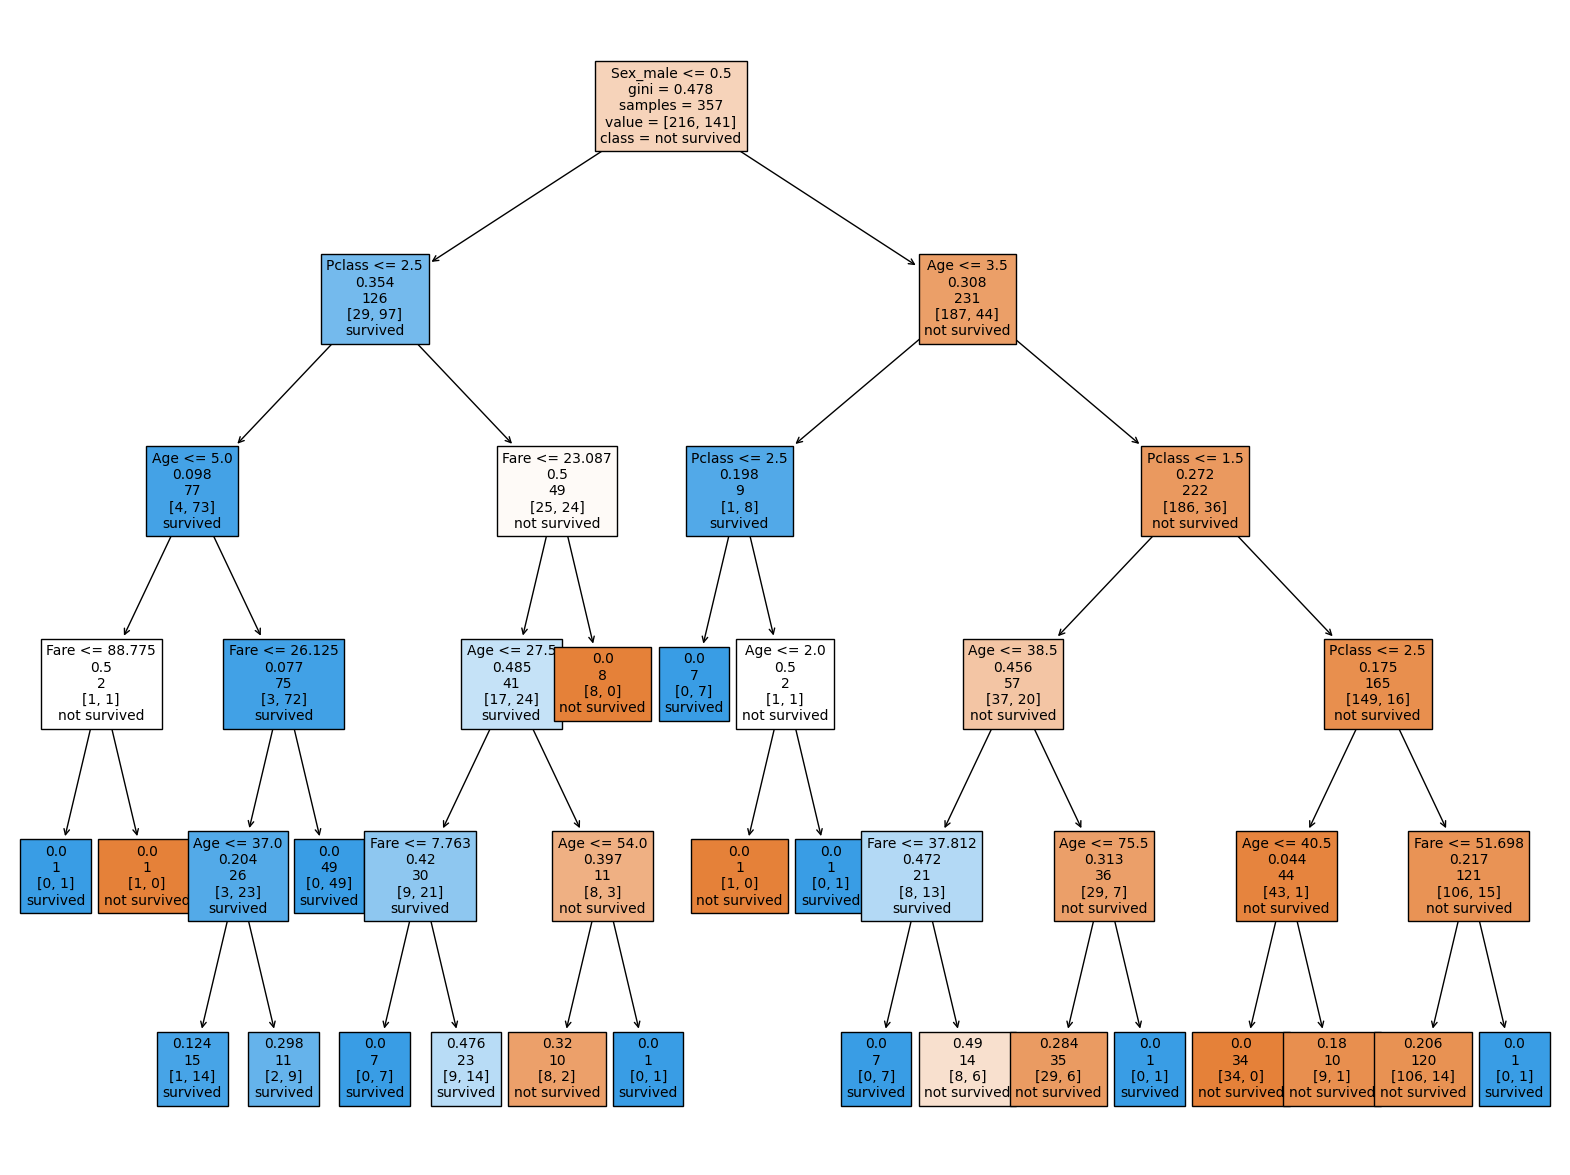

In [41]:
# Initialize the classification tree model 
clf2 = DecisionTreeClassifier(random_state=20, 
                             max_depth=5)

# Train the classification tree model 
clf2 = clf2.fit(X_train2, y_train2)

# Make model predictions
y_pred2 = clf2.predict(X_test2)
y_pred2


################

# Text representation of the classification tree
text_rep = tree.export_text(clf, 
                            feature_names=list(X_train.columns))

# Print text_representation
print(text_rep)


################

# For the meaning of numbers in boxes see root node
fig = plt.figure(figsize=(20,15))
tree_plot2 = tree.plot_tree(clf2, 
                   feature_names=list(X_train2.columns),  
                   class_names=['not survived', 'survived'],
                   filled=True,
                   fontsize=10,
                   label='root')


### Conclusion
<p> Since we have now increased the max_depth to 5, we naturally see more branches / decisions in the classification tree model. The question of how high to set the max_depth value depends on the goal. It is a trade-off between model complexity and model performance.
</p>

## Random Forest Classifier
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [42]:
# Create train and test samples
X3_train, X3_test, y3_train, y3_test = train_test_split(df_titanic[['Age', 
                                                                    'Sex_male',
                                                                    'Pclass',
                                                                    'Fare']], 
                                                        df_titanic['Survived'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X3_train
print('X3_train:')
print(X3_train.head(), '\n')

# Show y3_train
print('y3_train:')
print(y3_train.head())

X3_train:
      Age  Sex_male  Pclass     Fare
328  31.0     False       3  20.5250
73   26.0      True       3  14.4542
253  30.0      True       3  16.1000
719  33.0      True       3   7.7750
666  25.0      True       2  13.0000 

y3_train:
328    1
73     0
253    0
719    0
666    0
Name: Survived, dtype: int64


### Fit the Random Forest Classifier

In [43]:
# Initialize the random forest classifier
rfc = RandomForestClassifier(random_state=20, max_depth=10)

# Train the random forest classifier
rfc = rfc.fit(X3_train, y3_train)

# Predict the target variable (0 = not survived, 1 = survived)
y_pred_rf = rfc.predict(X3_test)

print('Predicted target variable (0 = not survived, 1 = survived)')
y_pred_rf

Predicted target variable (0 = not survived, 1 = survived)


array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1])

### Show confusion matrix and classification report

In [45]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y3_test, y_pred_rf), '\n')

# Classification report
print('Classification report')
print(classification_report(y3_test, y_pred_rf))

Confusion matrix
[[72 15]
 [16 40]] 

Classification report
              precision    recall  f1-score   support

           0       0.82      0.83      0.82        87
           1       0.73      0.71      0.72        56

    accuracy                           0.78       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143



### Show feature importance

Index(['Sex_male', 'Age', 'Fare', 'Pclass'], dtype='object')
[0.32834018 0.29770546 0.2695809  0.10437345]


<Axes: ylabel='features'>

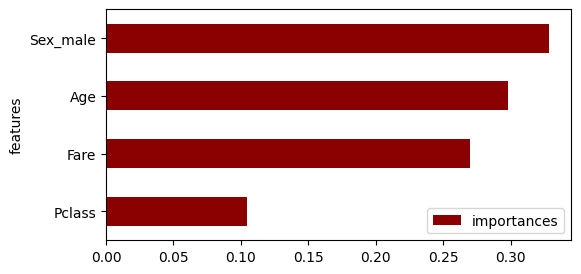

In [46]:
cols = X3_train.columns

# Derive feature importance from random forest
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

### ROC curve and AUC

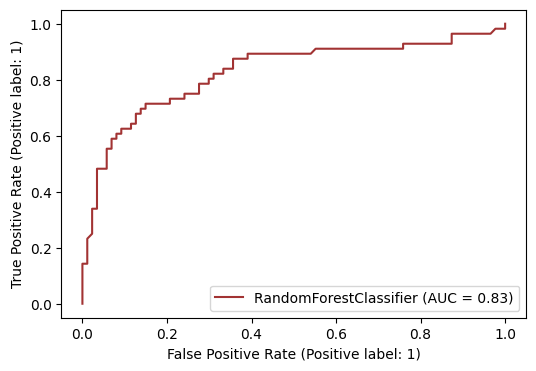

In [47]:
# Plot ROC curve and calculate AUC
plt.figure(figsize=(6,4))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, 
                                          X3_test, 
                                          y3_test, 
                                          ax=ax,
                                          alpha=0.8,
                                          c="darkred")
plt.show()

### SW09 - Task 1D/ 1E. New traind and test samples -> remove the variables 'age' & 'Sex_male'

X4_train:
     Pclass     Fare
328       3  20.5250
73        3  14.4542
253       3  16.1000
719       3   7.7750
666       2  13.0000 

y4_train:
328    1
73     0
253    0
719    0
666    0
Name: Survived, dtype: int64
Predicted target variable (0 = not survived, 1 = survived)
Confusion matrix
[[70 17]
 [28 28]] 

Classification report
              precision    recall  f1-score   support

           0       0.71      0.80      0.76        87
           1       0.62      0.50      0.55        56

    accuracy                           0.69       143
   macro avg       0.67      0.65      0.66       143
weighted avg       0.68      0.69      0.68       143

Index(['Fare', 'Pclass'], dtype='object')
[0.86079732 0.13920268]


<Axes: ylabel='features'>

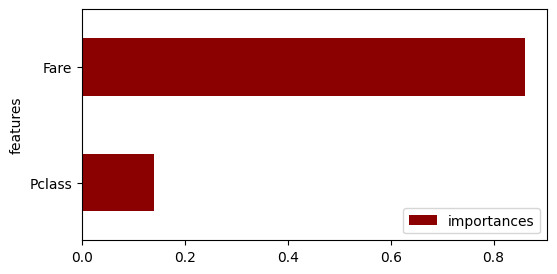

In [48]:
# Create train and test samples
X4_train, X4_test, y4_train, y4_test = train_test_split(df_titanic[[
                                                                    'Pclass',
                                                                    'Fare']], 
                                                        df_titanic['Survived'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X4_train
print('X4_train:')
print(X4_train.head(), '\n')

# Show y4_train
print('y4_train:')
print(y4_train.head())


################ Fit the Random Forest Classifier ################

# Initialize the random forest classifier
rfc2 = RandomForestClassifier(random_state=20, max_depth=10)

# Train the random forest classifier
rfc2 = rfc2.fit(X4_train, y4_train)

# Predict the target variable (0 = not survived, 1 = survived)
y_pred_rf2 = rfc2.predict(X4_test)

print('Predicted target variable (0 = not survived, 1 = survived)')
y_pred_rf2
################ Show confusion matrix and classification report ################
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y4_test, y_pred_rf2), '\n')

# Classification report
print('Classification report')
print(classification_report(y4_test, y_pred_rf2))


################ Show feature importance ################
cols = X4_train.columns

# Derive feature importance from random forest
importances = rfc2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc2.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))


### Conlusion
<p>
Well Sex_male & Age was both very important in the previous model. After removing it, the value of importances for the feature "Fare" increases rapidly from 0.2695809 to 0.86079732. (+ 219.02 %) and for PCclass +33.36% (from 0.10437345 to 0.13920268).
</p>

### Task 1.E Fit models with/without the varailes 'Age' and 'Sex_male' and state how the ROC curve and AUC value cahnge

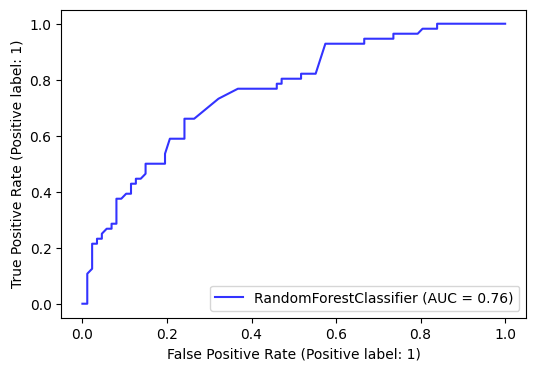

In [53]:
# Plot ROC curve and calculate AUC
plt.figure(figsize=(6,4))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc2, 
                                          X4_test, 
                                          y4_test, 
                                          ax=ax,
                                          alpha=0.8,
                                          c="blue")
plt.show()

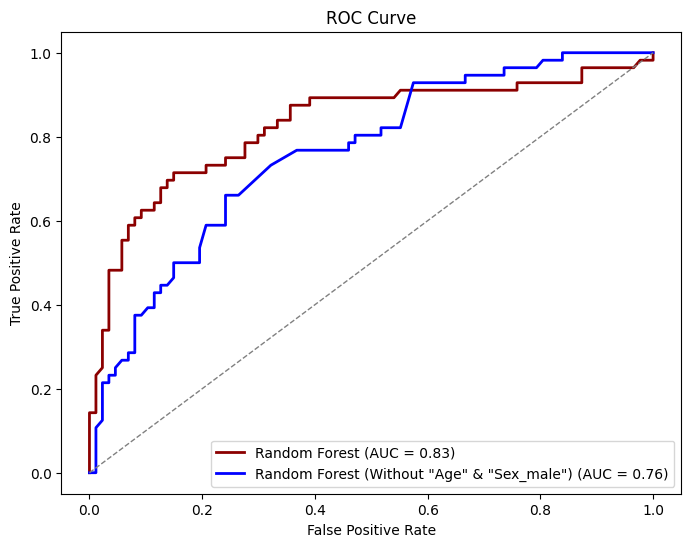

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Predict probabilities for each model
y_prob_rfc = rfc.predict_proba(X3_test)[:, 1]
y_prob_rfc2 = rfc2.predict_proba(X4_test)[:, 1]

# Compute ROC curve and ROC area for each model
fpr_rfc, tpr_rfc, _ = roc_curve(y3_test, y_prob_rfc)
fpr_rfc2, tpr_rfc2, _ = roc_curve(y4_test, y_prob_rfc2)

# Calculate AUC for each model
auc_rfc = roc_auc_score(y3_test, y_prob_rfc)
auc_rfc2 = roc_auc_score(y4_test, y_prob_rfc2)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc, tpr_rfc, color='darkred', lw=2, label=f'Random Forest (AUC = {auc_rfc:.2f})')
plt.plot(fpr_rfc2, tpr_rfc2, color='blue', lw=2, label=f'Random Forest (Without "Age" & "Sex_male") (AUC = {auc_rfc2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


### Conclusion
<p>
The first model (in red) has a better curve, which is closer to the upper left corner (1), which represent a better at differentiating between the classes, compared to the 2nd model (in blue, without the variables 'age' and 'Sex_male')
</p>

<p>
The AUC (Area Under the Curve) Value also represent the situation in the picture above
</p>

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [61]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 23.0.0
Datetime: 2023-11-18 10:53:10
Python Version: 3.9.6
-----------------------------------
